# 회원정보 EDA

- 필요한 라이브러리 설치 및 초기 설정

In [1]:
# %pip install -qU numpy pandas matplotlib fastparquet seaborn scikit-learn

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = 'C:/Windows/Fonts/NanumGothic.ttf' 
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

import sys
sys.path.append('../utils')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
from preprocessing import (
    DateElapsedTransformer, NumericFeaturePreprocessor, ObjectFeaturePreprocessor, NumericTypeOptimizer,
)

pre_optimizer = NumericTypeOptimizer(mode='pre')
date_transformer = DateElapsedTransformer()
numeric_transformer = NumericFeaturePreprocessor()
object_transformer = ObjectFeaturePreprocessor()
post_optimizer = NumericTypeOptimizer(mode='post')

preprocessing_pipeline = Pipeline([
    ('pre_optimizer', pre_optimizer),
    ('date', date_transformer),
    ('object', object_transformer),
    ('numeric', numeric_transformer),
    ('post_optimizer', post_optimizer),
])

# Set display configuration to visualize the pipeline
set_config(display='diagram')

# Display the pipeline
preprocessing_pipeline

Pipeline(steps=[('pre_optimizer', NumericTypeOptimizer(mode='pre')),
                ('date',
                 DateElapsedTransformer(base_date=Timestamp('2019-01-01 00:00:00'),
                                        exclude_columns=['ID', 'Segment',
                                                         '기준년월'])),
                ('object',
                 ObjectFeaturePreprocessor(exclude_columns=['ID', 'Segment'])),
                ('numeric',
                 NumericFeaturePreprocessor(exclude_columns=['기준년월'])),
                ('post_optimizer', NumericTypeOptimizer())])

In [4]:
from sklearn.preprocessing import LabelEncoder
from data_loader import load_data

member_df, member_test_df = load_data("1.회원정보")

X = member_df.drop(columns=['ID', 'Segment', '기준년월'])
y = member_df['Segment']

X = preprocessing_pipeline.fit_transform(X)
X_test = preprocessing_pipeline.transform(member_test_df.drop(columns=['ID', '기준년월']))

le = LabelEncoder()
y_encoded = le.fit_transform(y)

✅ File: ../../dataset/train/1.회원정보\201807_train_회원정보.parquet Completed!
✅ File: ../../dataset/train/1.회원정보\201808_train_회원정보.parquet Completed!
✅ File: ../../dataset/train/1.회원정보\201809_train_회원정보.parquet Completed!
✅ File: ../../dataset/train/1.회원정보\201810_train_회원정보.parquet Completed!
✅ File: ../../dataset/train/1.회원정보\201811_train_회원정보.parquet Completed!
✅ File: ../../dataset/train/1.회원정보\201812_train_회원정보.parquet Completed!
🔹 Shape : (2400000, 78)

✅ File: ../../dataset/test/1.회원정보\201807_test_회원정보.parquet Completed!
✅ File: ../../dataset/test/1.회원정보\201808_test_회원정보.parquet Completed!
✅ File: ../../dataset/test/1.회원정보\201809_test_회원정보.parquet Completed!
✅ File: ../../dataset/test/1.회원정보\201810_test_회원정보.parquet Completed!
✅ File: ../../dataset/test/1.회원정보\201811_test_회원정보.parquet Completed!
✅ File: ../../dataset/test/1.회원정보\201812_test_회원정보.parquet Completed!
🔹 Shape : (600000, 77)
Numeric Type Optimizer Transforming...
🧠 [mode=pre] 메모리 최적화: 3442.90 MB → 2513.64 MB (27.0% 감소)
Date

# Segment 분포 확인

Segment
A        972
B        144
C     127590
D     349242
E    1922052
Name: count, dtype: int64
Segment
A     0.04050
B     0.00600
C     5.31625
D    14.55175
E    80.08550
Name: proportion, dtype: float64


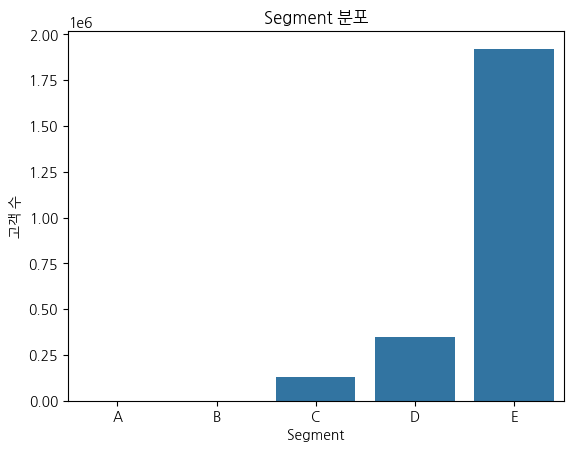

In [5]:
segment_count = y.value_counts().sort_index()
print(segment_count)
print("=" * 30)

segment_ratio = y.value_counts(normalize=True).sort_index()
print(segment_ratio * 100)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=segment_count.index, y=segment_count.values)
plt.title("Segment 분포")
plt.ylabel("고객 수")
plt.xlabel("Segment")
plt.show()

### 🔍 분석
- 극심한 클래스 불균형이 존재함.
  - Segment E 하나가 전체 고객의 80% 이상 차지
  - Segment A, B는 희소 클래스 (합쳐도 전체의 0.05% 수준)

- 클래스 불균형이 매우 심함.

> 👉 모델 학습 시 Segment A와 B를 예측하는 것이 매우 어려우며, 모델이 Segment E에 편향될 위험이 큼. 모델링 시 소수 클래스 예측을 위한 특수한 처리가 필수

# Feature Selection

## Feature Importance
- random forest를 이용하여 feature importance 측정
- Feature Scaling을 진행하지 않았기 때문에, 선형 모델을 이용하면 학습이 제대로 되지 않음.

In [6]:
from feature import FeatureSelector

feature_engineering_pipeline = Pipeline([
    ('feature_selector', FeatureSelector()),
    ('optimize', post_optimizer),
])

X = feature_engineering_pipeline.fit_transform(X, y_encoded)
X_test = feature_engineering_pipeline.transform(X_test)

🎯 Fitting RandomForest for Feature Selection...
✅ Selected 21 features out of 113
📊 Top Selected Features by Importance:
1) 	소지카드수_유효_신용 (0.0121)
2) 	소지카드수_이용가능_신용 (0.0201)
3) 	입회경과개월수_신용 (0.0465)
4) 	유효카드수_신용체크 (0.0123)
5) 	유효카드수_신용 (0.0149)
6) 	이용가능카드수_신용체크 (0.0248)
7) 	이용가능카드수_신용 (0.0202)
8) 	이용카드수_신용체크 (0.0473)
9) 	이용카드수_신용 (0.0402)
10) 	이용금액_R3M_신용체크 (0.1261)
11) 	이용금액_R3M_신용 (0.0870)
12) 	이용금액_R3M_체크 (0.0374)
13) 	_1순위카드이용금액 (0.1472)
14) 	_1순위카드이용건수 (0.0467)
15) 	_2순위카드이용금액 (0.0512)
16) 	_2순위카드이용건수 (0.0281)
17) 	이용여부_3M_해외겸용_본인 (0.0129)
18) 	이용여부_3M_해외겸용_신용_본인 (0.0126)
19) 	최종카드발급경과월 (0.0124)
20) 	입회일자_신용_경과일 (0.0533)
21) 	최종카드발급일자_경과일 (0.0177)


c:\Users\Lee JinSeoung\OneDrive\Desktop\4학년 1학기\고급프로그래밍\과제\Credit-Card-Segment-Classfication\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Numeric Type Optimizer Transforming...
🧠 [mode=post] 메모리 최적화: 384.52 MB → 70.95 MB (81.5% 감소)


c:\Users\Lee JinSeoung\OneDrive\Desktop\4학년 1학기\고급프로그래밍\과제\Credit-Card-Segment-Classfication\.venv\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Numeric Type Optimizer Transforming...
🧠 [mode=post] 메모리 최적화: 96.13 MB → 17.74 MB (81.5% 감소)


# 데이터 저장

In [10]:
import pandas as pd

train_df = pd.concat([member_df[['ID', '기준년월', 'Segment']], X], axis=1)
test_df = pd.concat([member_test_df[['ID', '기준년월']], X_test], axis=1)

train_df.to_parquet('../../dataset/train/member.parquet', index=False)
test_df.to_parquet('../../dataset/test/member.parquet', index=False)